### Automated Concept Extraction

There are several steps to the automated concept extraction method that are outlined in their paper [here]().

Firstly, we need to create patches from images that represent the object we want to derive concepts for. This involves using skimage segmentation and extracting the patches and superpixels from this. These will be used to find visual features that can be used as concepts.

Once we have the superpixels that we need, we can make use of a clustering technique on the representations extracted from the bottleneck layers of our model after passing a superpixel through. This will allow us to find visually similar images that will hopefully group patches that represent the same visual concept.

These groups of superpixels can then be used to create a concept activation vector. This involves getting the activations of these superpixels relating to a concept and then random superpixels that as a group represent no descernable concept. A linear classifier is trained on these examples and the vector orthognal to the hyperplane that separates the concept examples from the random is taken to be the concept activation vector.

The influence of this concept can be determined by taking the partial derivative of the class logit you want to examine with respect to a bottleneck layer. Multiplying the CAV by this partial derivative will allow us to determine the impact this concept had on the prediction.

This concludes the rough overview of the method that will be employed. The aim is to create realistic, reasonable concepts from the mitotic figures without the need of manually gathering images of specific concepts.

### Importing libraries

We will be making use of the following libraries to implement our method.

In [1]:
import sys
import random
from pathlib import Path
import numpy as np
import sklearn.metrics as metrics
from PIL import Image

import Utils.ACE.ace_helpers as ace_helpers
from Utils.ACE.ace import ConceptDiscovery

### Testing with COCO

We will begin by taking some images from the COCO dataset, specifically those inclusing a tennis racket. We will use this example to test our method and ensure we are processing the images correctly and the results seem reasonable. This seems the best course of action as I have a better understanding of the visual features that concern a tennis racket and no formal understanding of the visual features of a mitotic figure.

I believe that using the COCO images may result in poor concepts as the images are not specifically tennis rackets, but instead images that contain tennis rackets. This means that we will get many superpixels that are not relevant to tennis rackets.

In [2]:
# Create an output directory for our data
output = Path.cwd() / "ACE_COCO_output/"

# Create the sub directories at the output location.
ace_helpers.create_directories(output, remove_old=False)

In [3]:
# Specify the target class and the source directory.
# Note: The target class should be a folder in the source directory.
# This folder should have a folder called discovery for images for concept discovery and a folder called tcav for tcav score calculation.
target_class = "tennis racket"
source_dir = "D:\DS\DS4\Project\COCO"

We have defined the output path and the source directory where our images for discovery and tcav scores are stored.

Now we need to load in our model, this is wrapped in the ModelWrapper class which will extract the activations and gradients for us so we can cluster the superpixels, create cavs adn get tcav scores.

### Selecting the bottleneck layers

In order to extract the activations and gradients from a layer, we need to determine which layer(s) are bottleneck layers. A bottleneck layer typically reduces the number of channels in the data between the input and output while keeping the size of the image equal by using a kernel of (1,1) and a stride of (1,1). This means that the model compresses the representation of the input in this layer and keeps the most important features for performing the task. This makes it the ideal layer for using the activations from to cluster the superpixels for ACE and to train the linear classifier to find a CAV.

Looking at the model structure below we can see that there are several such layers in the backbone of our model. It may be worth just taking a selection of these. I have decided to take the bottleneck from the last bottleneck unit in each layer. This means I will be using the following 4 layers.

```
bottleneck_layers = ['backbone.body.layer1.2.conv1', 'backbone.body.layer2.3.conv1', 'backbone.body.layer3.5.conv1', 'backbone.body.layer4.2.conv1']
```

These will be the layers I extract both the activations from and the gradients when looking at the influence of each concept.

In [4]:
# Create a list of the bottleneck layers.
bottleneck_layers = ['backbone.body.layer1.2.conv1', 'backbone.body.layer2.3.conv1', 'backbone.body.layer3.5.conv1', 'backbone.body.layer4.2.conv1']

# Create the model variable and set it to evaluate.
mymodel = ace_helpers.MyModel("tmp", bottleneck_layers)
mymodel.model.eval()
mymodel.model.model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

### ConceptDiscovery class

Now that we have all of the required parameters, we can initialize the ConceptDiscovery class, which contains the methods for creating superpixels, clustering to find concepts, creating concept activation vectors and testing these. We will make use of this class for most of the notebook.

In [5]:
# Creating the ConceptDiscovery class instance.
cd = ConceptDiscovery(
    mymodel,
    target_class,
    source_dir,
    output,
    bottleneck_layers,
    num_random_exp=2,
    channel_mean=True,
    min_imgs=5)

Now we can call create_patches. This function takes the discovery images in the source directory and segments the image into superpixels for use later. The number of segments can be specified below.

These superpixels are then saved in the concept subdirectory of the output along with the patches and the discovery images.

In [6]:
# Creating the dataset of image patches.
cd.create_patches(param_dict={'n_segments': [15]})

ace_helpers.save_discovery_images(cd)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


The discover_concepts function takes all of the superpixels that were produced and determines possible concepts. This is done by passing the superpixels through the model and extracting the activations in the bottleneck layers. These representations of the superpixels can be clustered to find similar superpixels, which can be considered to be a possible visual concept.

In [7]:
# Discovering Concepts
cd.discover_concepts(method='KM', param_dicts={'n_clusters': 25})

Clustering to find potential concepts: 100%|█████████████████████████████████████████████| 4/4 [00:13<00:00,  3.33s/it]


True

Now we can save these discovered concepts to the concept folder for visual review and use later on when generating concept activation vectors.

In [8]:
# Save discovered concept images (resized and original sized)
ace_helpers.save_concepts(cd)

In order to test the validity of our findings, it is important to compare our CAV against a random concept. In addition, I will carry out a two-sided t-test in order to statistically quantify that the resultant scores are significantly different from one another. 

The initialize_random_concept_and_samples method creates a folder called Random in the concept directory and randomly samples superpixels for a random concept and a number of random samples for use as a random counterpart for CAV generation. This will allow us to determine that the found CAV from our clustered superpixels can explain the prediction better than a random selection, helping to qualify the findings.

In [9]:
cd.initialize_random_concept_and_samples()

The cavs method takes the superpixels from each of the concept directories and a random counterpart and finds the resultant CAV. A CAV will be generated for every pair of concept and random counterpart. If we are carrying out N experiments and we have M concepts discovered we will have N * (M + 1) CAVs, as we have to include the random concept with the M found potential concepts from clustering.

In [10]:
cav_accuracies = cd.cavs()

Calculating activations for superpixels: 100%|███████████████████████████████████████████| 3/3 [00:02<00:00,  1.42it/s]
Finding CAVs for all concepts in each bottleneck:   0%|                                          | 0/4 [00:00<?, ?it/s]
Calculating activations for superpixels: 100%|███████████████████████████████████████████| 8/8 [00:06<00:00,  1.18it/s]

Calculating activations for superpixels: 100%|███████████████████████████████████████████| 5/5 [00:04<00:00,  1.17it/s]

Calculating activations for superpixels: 100%|█████████████████████████████████████████| 11/11 [00:09<00:00,  1.18it/s]

Calculating activations for superpixels: 100%|███████████████████████████████████████████| 7/7 [00:05<00:00,  1.18it/s]

Calculating activations for superpixels: 100%|███████████████████████████████████████████| 8/8 [00:06<00:00,  1.24it/s]

Calculating activations for superpixels: 100%|███████████████████████████████████████████| 5/5 [00:03<00:00,  1.29it/s]

Calculating activations for superp

We can see the returned accuracies for each CAV generated (The experiments are listed). This helps us to understand how well the linear classifier splits the potential concepts superpixels from the randomly selected superpixels.

In [11]:
cav_accuracies

{'backbone.body.layer1.2.conv1': {'Random_concept': [0.5, 1.0],
  'tennis racket_concept1': [0.0, 1.0],
  'tennis racket_concept2': [0.5, 0.5],
  'tennis racket_concept3': [0.5, 1.0],
  'tennis racket_concept4': [0.5, 0.5],
  'tennis racket_concept5': [0.5, 0.5],
  'tennis racket_concept6': [0.5, 0.5],
  'tennis racket_concept7': [0.5, 1.0],
  'tennis racket_concept8': [1.0, 0.5]},
 'backbone.body.layer2.3.conv1': {'Random_concept': [0.5, 0.5],
  'tennis racket_concept1': [0.5, 0.5],
  'tennis racket_concept2': [1.0, 0.5],
  'tennis racket_concept3': [0.5, 1.0],
  'tennis racket_concept4': [0.5, 0.5],
  'tennis racket_concept5': [1.0, 0.5],
  'tennis racket_concept6': [0.5, 1.0],
  'tennis racket_concept7': [1.0, 1.0],
  'tennis racket_concept8': [1.0, 0.5],
  'tennis racket_concept9': [0.0, 1.0]},
 'backbone.body.layer3.5.conv1': {'Random_concept': [0.5, 0.5],
  'tennis racket_concept1': [0.5, 1.0],
  'tennis racket_concept2': [1.0, 1.0],
  'tennis racket_concept3': [0.5, 0.5],
  'ten

Now we can get a score of how influencial the individual CAVs are on all of the predictions on images from the tcav folder within the source directory.

This tcavs method takes the images from the tcav folder and calculates the gradients for the class of interest with respect to the bottleneck layers. These gradients are then multiplied by the CAV vector to determine how relevant the CAV is in the prediction. This results in a list of scores for each concept, an entry for each random counterpart/ experiment.

These scores are then used in a two-sided t-test with the random concept to determine if the potential concept is statistically different than a random selection of the superpixels. This will aid in validiating any findings from the method.

In [12]:
scores = cd.tcavs(test=False, sort=False)

Calculating gradients: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.17s/it]
Calculating TCAV scores for all concepts in each bottleneck: 100%|███████████████████████| 4/4 [00:00<00:00,  5.46it/s]


In [13]:
scores

{'backbone.body.layer1.2.conv1': {'tennis racket_concept1': [0.5384615384615384,
   0.5384615384615384],
  'tennis racket_concept2': [0.46153846153846156, 0.5384615384615384],
  'tennis racket_concept3': [0.38461538461538464, 0.46153846153846156],
  'tennis racket_concept4': [0.38461538461538464, 0.15384615384615385],
  'tennis racket_concept5': [0.23076923076923078, 0.15384615384615385],
  'tennis racket_concept6': [0.23076923076923078, 0.38461538461538464],
  'tennis racket_concept7': [0.5384615384615384, 0.38461538461538464],
  'tennis racket_concept8': [0.5384615384615384, 0.38461538461538464],
  'Random_concept': [0.23076923076923078, 0.5384615384615384]},
 'backbone.body.layer2.3.conv1': {'tennis racket_concept1': [0.9230769230769231,
   0.6153846153846154],
  'tennis racket_concept2': [0.6923076923076923, 0.23076923076923078],
  'tennis racket_concept3': [1.0, 0.46153846153846156],
  'tennis racket_concept4': [0.46153846153846156, 0.3076923076923077],
  'tennis racket_concept5':

The CAV accuracies and the TCAV scores can be saved into a report text file for review. This includes the average accuracy for a CAV, average tcav score for a CAV and the p-value from the t-test.

In [14]:
cd.save_ace_report()

D:\DS\DS4\Project\2023-ca4021-tegarta2\Utils\ACE\ace.py:1176: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, p = stats.ttest_rel(i_ups_concept[:min_len], i_ups_random[:min_len])


We can look at the superpixels that make up a concept to visually identify any characteristics that may have been used to cluster these superpixels together to find a potential concept.

In [15]:
# Plot examples of discovered concepts
for bn in cd.bottlenecks:
    cd.plot_concepts(bn, 10)

### Dimensionality reduction for clustering

The current implementation is averaging the activation values across the filters to reduce the dimensionality and allow the clustering to be performed. This is not the best approach to reduce the dimensionality while preserving as much information as possible. Improving this method will hopefully lead to more meaningful potential concepts.

In order the pick the best method for this application it would be best to understand the sparsity of the data we intend to run the dimensionality reduction on.

In [16]:
# Set the channel mean to false
cd.channel_mean = [False, False, False, False]

In [17]:
# Get the superpixel images
superpixels_dir = cd.discovered_concepts_dir / "superpixels"
superpixel_images = np.array(list(superpixels_dir.iterdir()))

# Get the activations back after passing the superpixels.
activations = cd._get_activations(superpixel_images)

Calculating activations for superpixels: 100%|█████████████████████████████████████████| 63/63 [00:54<00:00,  1.16it/s]


In [18]:
# For every bottleneck layer and their activations.
for bn, v in activations.items():
    
    # Get the count of nonzero values
    non_zero = np.count_nonzero(v)
    
    # Get the total number of entries in the array
    total = np.prod(v.shape)
    
    # The density is the non_zero count divided by the total entries.
    density = non_zero / total
    
    # Print the density for each.
    print(f"Density of {bn} is {density}")

Density of backbone.body.layer1.2.conv1 is 1.0
Density of backbone.body.layer2.3.conv1 is 1.0
Density of backbone.body.layer3.5.conv1 is 1.0
Density of backbone.body.layer4.2.conv1 is 1.0


We can see that there seems to be no zeroes present in any of the activation matrices. We can confirm this by counting the values that are zero in the matrices.

In [19]:
# For every bottleneck layer and their activations.
for bn, v in activations.items():
    
    # Get the sum of boolean values when array is == 0 i.e. the count of values that are 0
    zeroes = np.sum(v == 0)
    
    # Print the number of zeroes.
    print(f"The number of zeroes in {bn} is {zeroes}")

The number of zeroes in backbone.body.layer1.2.conv1 is 0
The number of zeroes in backbone.body.layer2.3.conv1 is 0
The number of zeroes in backbone.body.layer3.5.conv1 is 0
The number of zeroes in backbone.body.layer4.2.conv1 is 0


This means that we have dense arrays and it would be best to use principal component analysis PCA. This can be implemented through sci-kit learn with ease. Let us test this and see how much of the variance is preserved.

In [20]:
from sklearn.decomposition import PCA

# Set up the PCA model, preserve 99% of the variance
my_model = PCA(n_components= 0.99)

# Fit the data to the model and return the transformed data.
results = my_model.fit_transform(activations["backbone.body.layer1.2.conv1"])

# Print the cumulative sum of the variance ratios to understand how much variance is preserved after adding each variable.
print(my_model.explained_variance_ratio_.cumsum())

[0.23421751 0.31047112 0.3669015  0.41249156 0.44662973 0.4779989
 0.5053913  0.5276205  0.5468201  0.5650148  0.58206105 0.5966773
 0.60939693 0.6215733  0.63303953 0.6440954  0.6541826  0.66344625
 0.67252475 0.68128806 0.6896092  0.6978852  0.70574087 0.71313477
 0.72034365 0.727103   0.73377657 0.74034375 0.74679327 0.7530935
 0.7590809  0.76475227 0.7702006  0.7753945  0.7805446  0.78561056
 0.7905794  0.7953957  0.8000761  0.80467755 0.8091867  0.8135874
 0.8179215  0.82221866 0.8264386  0.83053625 0.8345409  0.83845985
 0.8423258  0.8460421  0.8497315  0.8533209  0.8568151  0.86024475
 0.8636161  0.86692154 0.8701987  0.8734422  0.87657374 0.8796847
 0.88273823 0.8857635  0.8887782  0.8916957  0.8945719  0.8973819
 0.90014195 0.90282667 0.9055053  0.90813893 0.9107601  0.9133457
 0.91589767 0.91837627 0.9208171  0.9232065  0.9255377  0.927828
 0.93009543 0.9323503  0.93457806 0.9367551  0.9388867  0.9409769
 0.94302607 0.9450703  0.94709504 0.94911164 0.9511062  0.953059
 0.9549

We can see that our PCA has complete and we have been returned the transformed data. Below we can look at the shape before and after.

In [21]:
# Print the old shape
print(activations["backbone.body.layer1.2.conv1"].shape)

# Print the new shape
print(results.shape)

(126, 2560000)
(126, 114)


The largest amount of features in the new space is the minimum between the number of samples and the number of features. This seems to work well, though this test set has only 126 activations for the superpixels coming from 10 images. The dataset that we have contains several tissue types, and the one that contains the most annotations has ~ 4,000 mitotic figures. This means that if we have roughly 10 segments per image, that will equate to ~ 40,000 activations being stored. This is not a feasible number to hold in memory. Below we determine the memnory usage for the current toy dataset.

In [22]:
# For every bottleneck layer and their activations.
for bn, v in activations.items():
    print(v.shape)
    
    # Get the array size in bytes and convert to MB.
    array_size = round(v.nbytes / 1024 / 1024,2)
    
    print(f"{bn} size of array is {array_size}MB")

(126, 2560000)
backbone.body.layer1.2.conv1 size of array is 1230.47MB
(126, 1280000)
backbone.body.layer2.3.conv1 size of array is 615.23MB
(126, 640000)
backbone.body.layer3.5.conv1 size of array is 307.62MB
(126, 320000)
backbone.body.layer4.2.conv1 size of array is 153.81MB


For 126 activations we have a memory usage of 1.23GB, ~ 10MB per image. So for the dataset we intend to use the memory usage would be 10MB * 40,000 = 400,000MB = 400GB. Even when we were averaging over the filters we were reducing the memory usage for each image by a factor of 64, so the usage would be ~6.25GB for the first layer, ~3GB for the second, ~1.5GB for the third and ~0.75GB for the last. So regardless, we need a method to reduce the dimensionality.

Thankfully, there is a PCA implementation for processing data in batches, which will allow us to process the activations one batch at a time and never have to hold them all in memeory. This will also result in better clusters as more information is preserved.

### Testing incremental PCA 

After attempting to make use of IncrementalPCA I found that the memory needed for a reasonable number of parameters was too large as the array had to have at least as many samples as we would like components. This led to me continuing with the averaging across channels approach for the first 3 layers and then using IncrementalPCA for all 4 layers. In this way, I was able to reduce the memory usage once PCA had ran and was able to get a better representation of the information in the activations extracted from the 4th layer, backbone.body.layer4.2.conv1.

This concluded the testing of various approaches to preserve variance in the extracted activations from the model.

### Sanity check

To ensure that the implementation is working as I expect it to I will check the following:

That the activations are equivalent both individually and in batches.

To check this I will manually run the activations both individually and in a batch and ensure the result is the same.

In [ ]:
# Load in some test files for passing to get activations
test_files = np.array(list((cd.discovered_concepts_dir / "superpixels").iterdir())[:2])

In [ ]:
# Get the activations with a batch size of 1.
acts = cd._get_activations(test_files, bs=1)

In [ ]:
# Get the gradients with a batch size of 2.
batch_acts = cd._get_activations(test_files, bs=2)

In [ ]:
# Check that the activations are equal.
np.unique(acts["backbone.body.layer1.2.conv1"] == batch_acts["backbone.body.layer1.2.conv1"])

We can see that the activations are equivalent, so we have checked this.

Next, I want to check that the hooks don't require the gradients to be zeroed and are not being accumulated.

This will involve getting the returned gradients, and ensuring that every element in the list is not smaller than the next element in the list. If the gradients were accummulating, this would be the case.

In [ ]:
# Get the gradients for our test images.
grads, _ = cd._return_gradients(test_files, test=False)

In [ ]:
# Check that every value in gradient i-1 in the list is not smaller than in gradient i.
layer_grads = grads["backbone.body.layer1.2.conv1"]
for i in range(1, len(layer_grads)):
    print(np.unique(layer_grads[i - 1] <= layer_grads[i]))

We can see that there are instances where this is false, so the gradient in gradient i-1 is greater than in gradient i at some values. This shows that the gradients are not being accummulated.

Lastly, I want to ensure that the method of calculating the TCAV score is working as expected and producing correct scores. This will involve manually running the method and ensuring the output is correct.

In [ ]:
# Get some gradients to use
gradients, _ = cd._return_gradients(test_files)

In [ ]:
cd._tcav_score("backbone.body.layer1.2.conv1", "tennis racket_concept1", "Random_001", gradients)

In [ ]:
# Get the CAV vector.
tmp_vector = cd.load_cav_direction("tennis racket_concept1", "Random_001", "backbone.body.layer1.2.conv1")

# Check the shape of the vector.
tmp_vector.shape

In [ ]:
# Get these test gradients.
test_grads = gradients["backbone.body.layer1.2.conv1"]

# Check the test gradients shape.
len(test_grads), len(test_grads[0])

In [ ]:
# Multiply the vector against the gradient.
prod = (test_grads * vector)
prod.shape

In [ ]:
# Get the sum along axis 1 so we have the dot products.
dot_products = np.sum(prod, -1)

In [ ]:
# Get the average value of the booleans returned.
np.mean(dot_products < 0)

We can see that the resultant score is identical for both. The manual method I have used follows the original implementation of the tcav score in the paper.

### ACE on Mitotic figures

Now I will run all of the previously tested code on the Mitotic Figure data that I have processed. I have opted to do this through a standalone python script as this will reduce the memory in use as I do not have tabs open within Jupyter. This is important as memory is the primary bottleneck for my machine to carry out this task. The code for running all of the previously used methods can be seen below and is in the Utils/ACE/run_ace.py script in the project repo.

In [ ]:
from pathlib import Path
import numpy as np
import os
import sys

# This allows the other ACE files to be imported as they cannot be found in sys.path.
sys.path.append(str(Path.cwd().absolute()))

import Utils.ACE.ace_helpers as ace_helpers
from Utils.ACE.ace import ConceptDiscovery

def main():

    # Specify the target class and the source directory.
    # Note: The target class should be a folder in the source directory.
    # This folder should have a folder called discovery for images for concept discovery and a folder called tcav for tcav score calculation.
    target_class = "mitotic figure"
    source_dir = Path("D:/DS/DS4/Project/Mitotic_figures")
    
    # Create a list of the bottleneck layers.
    bottleneck_layers = ['backbone.body.layer1.2.conv1', 'backbone.body.layer2.3.conv1', 'backbone.body.layer3.5.conv1', 'backbone.body.layer4.2.conv1']

    # Create the model variable and set it to evaluate.
    mymodel = ace_helpers.MyModel("mitotic", bottleneck_layers)
    
    # List the different datasets/tissues we want to use. 
    tissue_types = ['canine cutaneous mast cell tumor', 'canine lung cancer', 'canine lymphoma', 'human breast cancer', 'human neuroendocrine tumor']
    
    # Loop through these to find potential concepts for each.
    for tissue_type in tissue_types:
        try:
        
            print(tissue_type, "Running")
            
            # create a path to the data we are currently using.
            curr_source_dir = source_dir / tissue_type

            # Create an output directory for our data.
            output = Path("D:/FYP") / f"ACE_mitotis_{tissue_type}/"
            
            # Create the directories that we intend to output files to.
            ace_helpers.create_directories(output, remove_old=False)

            # Creating the ConceptDiscovery class instance.
            cd = ConceptDiscovery(
                mymodel,
                target_class,
                curr_source_dir,
                output,
                bottleneck_layers,
                num_random_exp=25,
                channel_mean=[True, True, True, False],
                min_imgs=50,
                resize_dims=(512,512),
                pca_n_components=[600, 200, 100, 600])

            # Creating the dataset of image patches by segmenting the discovery images.
            patches_created = cd.create_patches(param_dict={'n_segments': [10]})
            
            # Once this is complete (patches_created is a boolean stating if the process ran) we will create patches from the context images.
            # The motivation for this is that we will get segments that relate to the context around the annotation, which can be used to
            # classify mitotic figures. This context may capture how close neighbouring cells are, which can sometimes be used to identify
            #mitotic figures.
            if patches_created:
                
                # Get the list of context discovery images from the directory.
                context_discovery_images = list((curr_source_dir / target_class / "context_discovery").iterdir())
                
                # Create the context patches.
                cd.create_patches(param_dict={'n_segments': [4]}, discovery_images=context_discovery_images)
                
                # We want to save the context images to our output. This will be useful later when we plot the outputs as the context
                # images contains the annotation and some additional context.
                ace_helpers.save_discovery_images(cd,save_context=True)
            
            # The following section was used as a means to update the PCA once it was already computed.
            
            # Load the superpixel images that will be used to update the PCA.
            superpixels_dir = cd.discovered_concepts_dir / "superpixels"
            superpixel_images = np.array(list(superpixels_dir.iterdir()))

            # Define the batch size that the activations were computed in (they were stored and used repeatedly as I was
            # troubleshooting memory issues).
            bs = 2
            
            # For every bottleneck and incremental PCA object.
            for bn, pca_n_components in zip(cd.bottlenecks, cd.pca_n_components):
                
                # Logic to ensure that the correct PCA object is updated.
                if bn in ['backbone.body.layer2.3.conv1', 'backbone.body.layer3.5.conv1'] and tissue_type not in ['canine cutaneous mast cell tumor']:
                    cd.update_pca(bn, pca_n_components, superpixel_images, bs)

            # If we have a PCA object, print the variance that we have preserved.
            if hasattr(cd, "pca") and cd.pca is not None:
                check_pca_variance_preserved(cd)

            print("Starting concept discovery")

            # Discovering Concepts through clustering of segment activations.
            concepts_ran = cd.discover_concepts(method='KM', param_dicts={'n_clusters': 50})
            
            # If we successfully discovered concepts, save them to the output.
            if concepts_ran:
                print("Saving concepts")
                # Save discovered concept images (resized and original sized)
                ace_helpers.save_concepts(cd)

            # Randomly select image segments to create a random concept and random groups to train the concepts against.
            # The random concept will allow us to test if our discovered concepts are statistically different from a random sample.
            # The random groups (25) will allow us to generate 25 different vectors for each concept against the random group. 
            print("Initializing random concepts")
            cd.initialize_random_concept_and_samples()

            # Now we calculate the CAVs by creating a linear classifier that splits the concept activations from the random activations.
            # The vector orthognal to the decision boundary gives us the vector that represents the concept.
            print("Computing CAVs")
            cav_accuracies = cd.cavs()

            # Now we compute the TCAV scores by getting the product of our gradients by the CAV and assessing how many of the predictions
            # it had a positive impact on.
            print("Computing TCAV scores")
            scores = cd.tcavs(test=False, sort=False)

            # Generate a textual report that contains how well the CAVs were split from the random, the average TCAV score of the concepts
            # and a p-value for a 2 sided t-test to see if the concepts tcav scores were statistically different from the random concept's scores.
            print("Generating report")
            cd.save_ace_report()

            # Plot examples of discovered concepts and also the concepts that were influential and statistically different from the random
            # concept.
            for bn in cd.bottlenecks:
                cd.plot_concepts(bn)
                cd.plot_influential_concepts(bn, 30, 10)
        
        # If we encounter an exception, print it and move on to the next tissue.
        except Exception as e:
            print(e)


def check_pca_variance_preserved(cd):
    """
    This function takes a ConceptDiscovery instance and prints the variance
    preserved in the IncrementalPCA object for each bottleneck."""
    
    # For every layer and PCA instance.
    for layer, pca_instance in cd.pca.items():
        
        # Print the cumulative variance explained.
        print(layer, pca_instance.explained_variance_ratio_.cumsum()[-1])
    
if __name__ == "__main__":
    main()


This script tooks several days to run in entirety, as a result of the segments produced from each annotation. I made the decision to capture segments at a low-level and a zoomed out level, an example of the 2 different images used can be seen below.

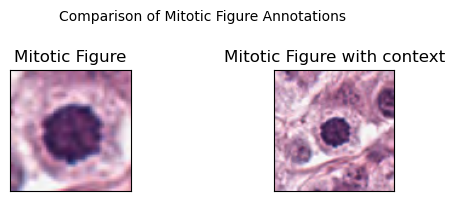

In [38]:
import matplotlib.pyplot as plt

data_path = Path("D:\DS\DS4\Project\Mitotic_figures\canine cutaneous mast cell tumor\mitotic figure")

discovery_path = data_path / "discovery"
context_path = data_path / "context_discovery"

discovery_image = plt.imread(list(discovery_path.iterdir())[0])
context_image = plt.imread(list(context_path.iterdir())[0])

fig, ax = plt.subplots(1, 2, figsize=(6,2))

ax[0].imshow(discovery_image)
ax[1].imshow(context_image)

ax[0].set_title('Mitotic Figure')
ax[1].set_title('Mitotic Figure with context')

ax[0].tick_params(left=False, bottom=False)
ax[1].tick_params(left=False, bottom=False)

ax[0].set(yticklabels=[], xticklabels=[])
ax[1].set(yticklabels=[], xticklabels=[]) 

title = 'Comparison of Mitotic Figure Annotations'
fig.suptitle(title, fontsize=10)
plt.tight_layout()
plt.show()

The motivation for this was to capture features regarding the context that the mitotic figure occurs in, such as the space between cells and number of neighbouring cells. This is a visual feature that can sometimes be used as a means of identifying a mitotic figure acording to literature.

All the files produced from running this script exceeded 170GB, so I will not be able to upload them all. I will upload the concept vectors produced, the set of concepts found, the resultant scores and report, the PCA file and the plots of concepts for visual assessment. The activations produced cannot be added to Google Drive due to the sheer volume of them, so I will exclude them from the data uploaded for this project.

As I have made use of PCA in the last layer alone, I hope to see some interesting concepts forming there as a result of the additional information which is preserved.

### Creating Visualisations from the results

I will make use of the TCAV scores and the p-values for the two-sided t-test to understand how influential and statistically different than the random concepts each of the potential concepts was. I will put emphasis on the last layer here as the concepts derived from it should be more representative of the underlying data as a result of the use of PCA on this layer.

In [34]:
import pickle

# List the different datasets/tissues we want to use. 
tissue_types = ['canine cutaneous mast cell tumor', 'canine lung cancer', 'canine lymphoma', 'human breast cancer', 'human neuroendocrine tumor']

tissue_scores = {}

# Loop through these to find potential concepts for each.
for tissue_type in tissue_types:
        
    cav_dir = Path(f"D:/FYP/ACE_mitotis_{tissue_type}/cavs")
#     tissue_concepts_scores[tissue_type]["concepts"] = cd.dic

    # Open the concept dictionary file and save it to self.dic
    with open(cav_dir / 'tcav_scores.pkl', 'rb') as handle:
        tissue_scores[tissue_type] = pickle.load(handle)
        print(f"Loaded TCAV scores for {tissue_type} concepts")
        
    print(f"Finished {tissue_type}")
    print()

Loaded TCAV scores for canine cutaneous mast cell tumor concepts
Finished canine cutaneous mast cell tumor

Loaded TCAV scores for canine lung cancer concepts
Finished canine lung cancer

Loaded TCAV scores for canine lymphoma concepts
Finished canine lymphoma

Loaded TCAV scores for human breast cancer concepts
Finished human breast cancer

Loaded TCAV scores for human neuroendocrine tumor concepts
Finished human neuroendocrine tumor



In [35]:
import scipy.stats as stats

def do_statistical_testings(concept_scores, random_scores):
    """Conducts ttest to compare two set of samples.

    In particular, if the means of the two samples are staistically different.

    Args:
      i_ups_concept: samples of TCAV scores for concept vs. randoms
      i_ups_random: samples of TCAV scores for random vs. randoms

    Returns:
      p value
    """

    min_len = min(len(concept_scores), len(random_scores))
    _, p = stats.ttest_rel(concept_scores[:min_len], random_scores[:min_len])
    return p

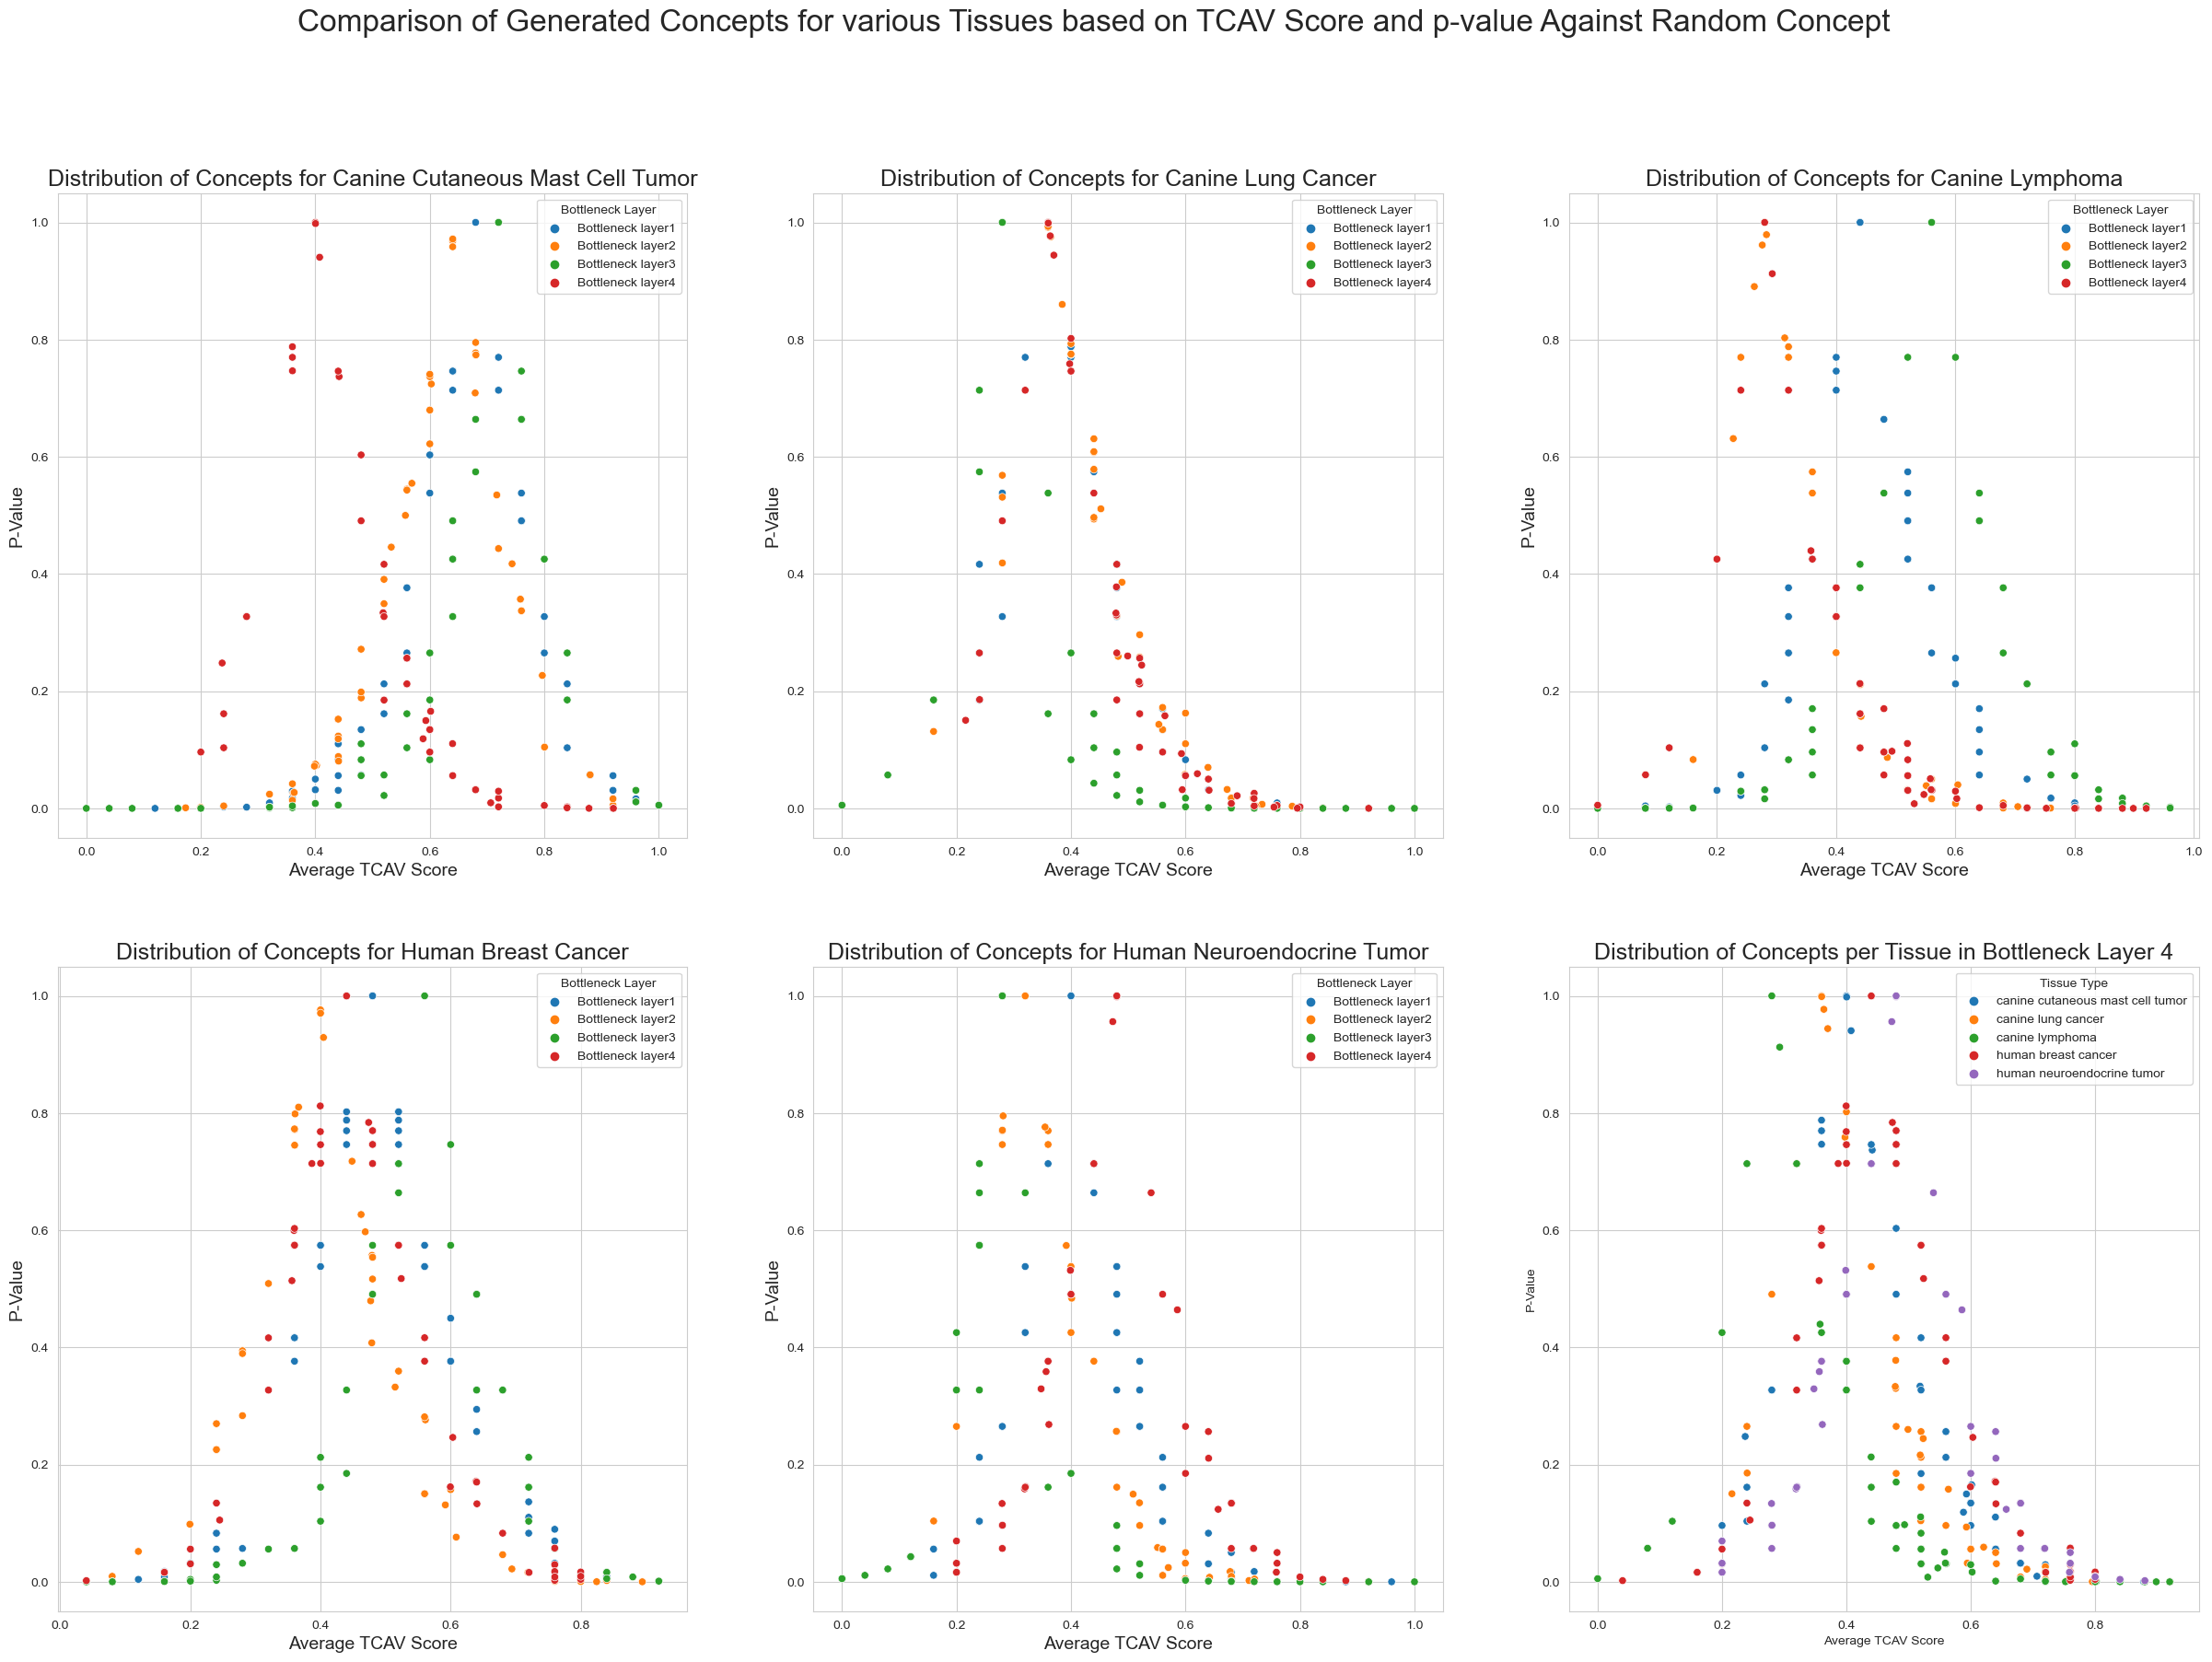

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_style("whitegrid")


i = 0
rows = 2
columns = 3

fig, axs = plt.subplots(rows, columns, figsize=(30, 20))

fig.suptitle("Comparison of Generated Concepts for various Tissues based on TCAV Score and p-value Against Random Concept", fontsize=24)

final_layer_data = None

for tissue_type, scores in tissue_scores.items():
    
    current_row, current_column = divmod(i, columns)
    
    current_ax = axs[current_row, current_column]
    current_ax.set_title(f'Distribution of Concepts for {" ".join([w.capitalize() for w in tissue_type.split(" ")])}', size=18)
    current_ax.set_ylabel("P-Value", fontsize = 14)
    current_ax.set_xlabel("Average TCAV Score", fontsize = 14)
    
    
    tissue_data = None
    
    for bn_layer, concepts in scores.items():
        
        bn_name = "Bottleneck " + bn_layer.split(".")[2]
        
        current_concepts = concepts.copy()
        
        random_concept = current_concepts.pop("Random_concept")
        
        concept_names = current_concepts.keys()
        
        concept_scores = [np.mean(values) for values in current_concepts.values()]
        
        concept_p_values = [do_statistical_testings(values, random_concept) for values in current_concepts.values()]
        
        data_dict = {"Concept Name": concept_names, "Average TCAV Score": concept_scores,
                     "P-Value": concept_p_values, "Bottleneck Layer": [bn_name] * len(concept_names),
                     "Tissue Type": [tissue_type] * len(concept_names)}
        
        if tissue_data is None:
            tissue_data = pd.DataFrame(data_dict)
            
        else:
            tissue_data = pd.concat([tissue_data, pd.DataFrame(data_dict)])
            
        if bn_layer == 'backbone.body.layer4.2.conv1':
            
            if final_layer_data is None:
                final_layer_data = pd.DataFrame(data_dict)
            
            else:
                final_layer_data = pd.concat([final_layer_data, pd.DataFrame(data_dict)])
    
    sns.scatterplot(ax=current_ax, data=tissue_data, x="Average TCAV Score", y="P-Value", hue="Bottleneck Layer")
    
    i += 1

final_layer_ax = current_ax = axs[1, 2]

final_layer_ax.set_title(f'Distribution of Concepts per Tissue in Bottleneck Layer 4', size=18)

sns.scatterplot(ax=final_layer_ax, data=final_layer_data, x="Average TCAV Score", y="P-Value", hue="Tissue Type")

plt.show()

### Limitations

I feel it is important to highlight some limitations within my approach, this will help to give a better understanding of what I have learned from the process and would consider if I were to continue this project.

#### Memory Issues

The bulk of the limitations I faced were due to hardware. These involved waiting large periods of time for results due to the volume of the data I wished to process.

There were several methods I had to settle for less than perfect solutions as a means of being able to carry out the project. These included losing the variance for the activations as the returned activations were too large for me to carry out IncrementalPCA or any other form of dimensionality reduction I could easily make use of. Additionally, I had to take a small subsample of the images for a potential concept as taking all images would be expensive. The motivation was that the representation would hopefully be a good approximation of the concept, but it would not be perfect.

#### Time contraints

I had hoped to make use of this methods for different numbers of clusters, different clustering techniques and numbers of segments. This process took much longer than I had initially anticipated to run, mainly due to the increase in images to process as each segment became a new image. If I had better hardware I could have made better use of the time instead of debugging how I can fit something into memory that unfortunately cannot fit.

#### Implementation

I was not concerned with the accuracy of the Object Detection model, and I believe more appklicable results could be found if there is additional time to fine-tune a model. Additionally, I decided to use the Faster R-CNN model as it allowed for a good accuracy for my use case and allowed me to spend more time focusing on the concept extraction portion of the project.

With regard to the CAV sensitivity, I was only interested in understanding if I could find influential CAVs and was not focused on quantifying how influential they are. There are methods that can be used as a means of quanitfying this value, but I deemed it was not essential for my use case.

Overall, I have learned some valuable lessons from undertaking this project that I will make use of in future projects.